In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import copy
import glob
sys.path.insert(1, '/export03/data/opt/Hippo_Spin_Testing')
from hippo_spin_testing import spin_test
sys.path.insert(1, '/data/mica1/01_programs/micapipe-v0.2.0/functions')
from build_mpc import build_mpc
from brainspace.gradient import GradientMaps

In [3]:
downsampled_histo = np.load("../checkpoints/struct-HISTO-proc-averaged.npy")
cdata = np.load("../checkpoints/struct-PNI-averaged.npy")
struct_data = np.concatenate((downsampled_histo,cdata),axis=2)

allfeatures = ['Merker', 'PLI-transmittance', 'Blockface', 'Bieloschowsky', 'Calbindin', 'Calretinin', 'Parvalbumin', 'Thionin', 'ProtonDensity', 'qR1', 'qR2star', \
               'T1map', 'MTR', 'T2star', 'FA', 'ADC']

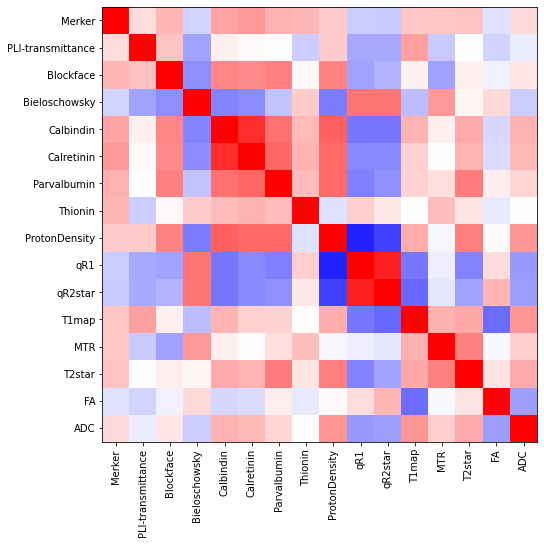

In [4]:
# correlation between features
feat_corr = np.corrcoef(struct_data.reshape(7262*17,16).T)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(feat_corr, vmin=-1, vmax=1, cmap='bwr')
plt.yticks(ticks=range(len(allfeatures)),labels=allfeatures);
plt.xticks(ticks=range(len(allfeatures)),labels=allfeatures, rotation=90);

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


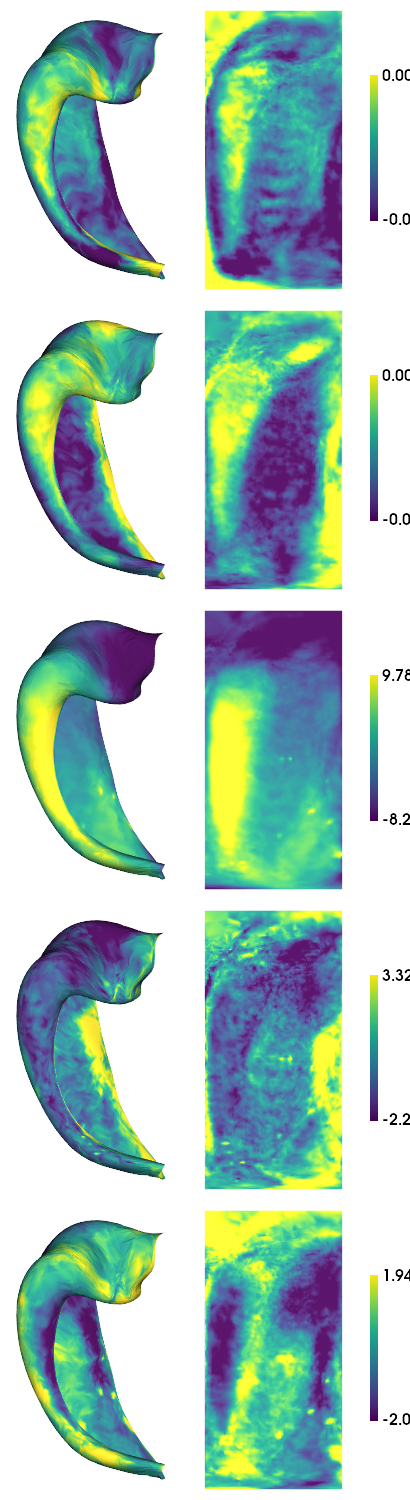

In [5]:
# gradient decomposition
ngrads=5
mmgm = GradientMaps(n_components=ngrads, kernel='cosine', random_state=0)
mmgm.fit(struct_data.reshape(7262,17*16), sparsity=0.1)
plotting.surfplot_canonical_foldunfold(mmgm.gradients_, labels=['hipp'], hemis=['L'], unfoldAPrescale=True, color_bar='right', share='row', tighten_cwindow=True, embed_nb=True)

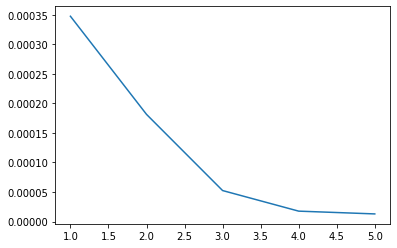

In [6]:
plt.plot(np.arange(ngrads)+1,mmgm.lambdas_)